## Ensemble variation in cloud cover
### GEFS TCC
The NOAA GEFS numerical weather prediction (NWP) model is a 30-member ensemble version of the GFS model. NOAA has this description:
> The GEFS attempts to quantify the amount of uncertainty in a forecast by generating an ensemble of multiple forecasts, each minutely different, or perturbed, from the original observations. With global coverage, GEFS is produced four times a day with weather forecasts going out to 16 days.

We will look at the fleet-wide weighted average standard deviation of the Total Cloud Cover (TCC) percentage across all 30 members, weighted by the solar plant capacities. For example, if all 30 members forecast that a given location and time will have no clouds (TCC = 0%), then the standard deviation will be *low*, so we assume that our power forecast has *low uncertainty*. If there is significant disagreement between the 30 members (some members forecast no or low cloud cover, while others forecast high cloud cover), then the standard deviation will be *high*, and we assume that any forecast will have *high uncertainty*. 

We use TCC instead of irradiance for two reasons: 
 1) GEFS may have issues with modeling irradiance*, and, more importantly
 2) We are looking at *relative* uncertainty, and using TCC means we don't have to normalize irradiance to clear sky irradiance. 

_Note: Total CLoud Cover does not differentiate between low, mid, and high clouds, which can have different impacts on irradiance [1]. However, the regression models used later to estimate uncertainty were retrained with seperate cloud cover variables (and combinations of two of the three), and results did not appear to improve. This is an area for potential exporation/improvement. Similarly, irradiance (DSWRF) from GEFS was not tested in this work, but may ebe useful after normalizing the clear sky irradiance._

*See https://www.energy.gov/sites/default/files/2019/10/f67/7%20Solar-Forecasting-2-Annual-Review_University-of-Arizona.pdf and https://pvlib-python.readthedocs.io/en/v0.4.0/forecasts.html. 

[1] https://pdfs.semanticscholar.org/ab2c/0cf0f80d6775ab49ea86fa34dbdccf7dbae8.pdf

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from herbie import Herbie, FastHerbie
from toolbox import EasyMap, pc
import xarray as xr
import pandas as pd

## Plant data

Let's load plant data again:

In [2]:
plants_df = pd.read_csv('pv_fleet_metadata_rev3.csv') # read in as a Pandas DataFrame
plants_df = plants_df[plants_df['ac_capacity']>=10].copy().reset_index()
num_plants = len(plants_df.index) # number of plants

To keep it simple at the beginning, let's just work with the first 2 plants:

In [3]:
plants_df_partial = plants_df.head(2).copy()

### GEFS Total Cloud Cover
Now, let's use `Herbie` to get Total Cloud Cover from GEFS. Total Cloud Cover is `TCDC` in the GEFS inventory, even though we refer to it as TCC elsewhere. We will also pick a single member of the GEFS ensemble - let's use "p01" to start. See [1] for more details.

[1] https://herbie.readthedocs.io/en/stable/user_guide/_model_notebooks/gefs.html

In [4]:
date = '2021-04-09 06:00'
member='p01'
ds = Herbie(
    date=date,
    model='gefs',
    product="atmos.5",
    member=member,
    fxx=36).xarray('TCDC',remove_grib=True)

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


And preview the dataset. Note that "tcc" is the variable name for Total Cloud Cover within the xarray dataset.

In [5]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:              (latitude: 361, longitude: 720)
Coordinates:
    number               int32 4B 1
    time                 datetime64[ns] 8B 2021-04-09T06:00:00
    step                 timedelta64[ns] 8B 1 days 12:00:00
    atmosphere           float64 8B 0.0
  * latitude             (latitude) float64 3kB 90.0 89.5 89.0 ... -89.5 -90.0
  * longitude            (longitude) float64 6kB 0.0 0.5 1.0 ... 359.0 359.5
    valid_time           datetime64[ns] 8B ...
Data variables:
    tcc                  (latitude, longitude) float32 1MB ...
    gribfile_projection  object 8B None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs
    product:                 atmos.5
    description:             Global Ensemble Forecast System (GEFS)
    remote_grib:             https://noaa-gefs-pds.s3.amazonaws.com/gefs.2021...
    local_grib:              C:\Users\willh\data\gefs\20210409\subset_c90efd3...
    searchString:            TCDC

Similar to what we did with the HRRR forecast, we will slice the dataset to reduce file size and make it easier to plot. Note that GEFS is mush lower resolution than HRRR, so file size is not a big issue. 

In [6]:
# Define extent (left lon, right lon, lower lat, upper lat)
# longitude has to be between 0 and 360
region_extent = [-92, -80, 29, 36]

min_lon = (region_extent[0]+360) % 360
max_lon = (region_extent[1]+360) % 360
min_lat = region_extent[2]
max_lat = region_extent[3]

# slice to region extent
# note that lat is sliced max to min because of order that latitude is stored in with GEFS
# (I think...)
ds = ds.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))

### Pull TCC for each plant
Now, let's pull out the data from the dataset for each plant and put it in a dataframe:

In [7]:
# GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
lon_gefs = [(x + 360) % 360 for x in plants_df_partial.longitude]

# select the whole list of sites at once
lats = xr.DataArray(plants_df_partial.latitude.values, dims='plant_number') 
lons = xr.DataArray(lon_gefs, dims='plant_number')
df1 = ds.sel(latitude = lats, longitude = lons, method = 'nearest').to_dataframe()

# assign ac capacity based on plant_number and index in plants_df_partial
df1 = df1.merge(plants_df_partial[['ac_capacity']], left_on='plant_number', right_index=True)

# preview the dataframe
df1.head()

,number,time,step,atmosphere,latitude,longitude,valid_time,tcc,gribfile_projection,ac_capacity
plant_number,,,,,,,,,,
0,1,2021-04-09 06:00:00,1 days 12:00:00,0.0,30.5,275.5,2021-04-10 18:00:00,45.0,None,213.0
1,1,2021-04-09 06:00:00,1 days 12:00:00,0.0,32.5,276.5,2021-04-10 18:00:00,82.0,None,204.0


And let's make a map. 

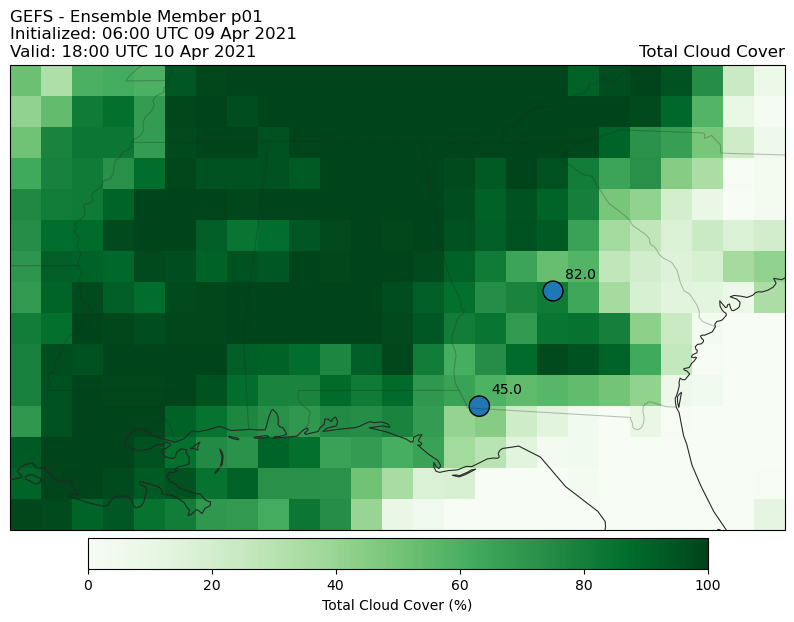

In [8]:
ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 10]).STATES().BORDERS().ax
p = ax.pcolormesh(
    ds.longitude, ds.latitude, ds['tcc'], transform=pc, cmap="Greens", vmin=0
)

# add a colorbar
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    label=f"{ds['tcc'].GRIB_name} ({ds['tcc'].GRIB_units})",
)

# add plant markers with size corresponding to ac capacity
plt.scatter(plants_df_partial.longitude, plants_df_partial.latitude, s=plants_df_partial.ac_capacity,
            edgecolors='black', transform=pc)

# add data labels
for i, txt in enumerate(df1['tcc']):
    plt.annotate(txt, (plants_df_partial.longitude[i]+.2, plants_df_partial.latitude[i]+.2))

ax.set_title(
    f"{ds.model.upper()} - Ensemble Member {member} \
    \nInitialized: {ds.time.dt.strftime('%H:%M UTC %d %b %Y').item()} \
    \nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(ds['tcc'].GRIB_name, loc="right")
plt.show()

### Weighted average TCC
We can calculate the weighted average total cloud cover, weighted by plant AC capacity, like this:

In [9]:
weighted_avg_tcc1 = df1.filter(regex='tcc').multiply(df1['ac_capacity'].values,axis='index').sum()/df1['ac_capacity'].sum()
weighted_avg_tcc1 = weighted_avg_tcc1.values[0]
print('Weighted Average TCC: ' + str(weighted_avg_tcc1))

Weighted Average TCC: 63.10071942446043


### Repeating for more ensemble members
Now, let's make a helper function to repeat that for different forecasts/members:

In [10]:
def sample_tcc_function(member, date, plants_df, plot=True):
    ds = Herbie(
        date=date,
        model='gefs',
        product="atmos.5",
        member=member,
        fxx=36).xarray('TCDC',remove_grib=True)

    # slice to region extent
    ds = ds.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))

    # select values for each plant, assign ac capacity
    # GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
    lon_gefs = [(x + 360) % 360 for x in plants_df.longitude]
    lats = xr.DataArray(plants_df.latitude.values, dims='plant_number') 
    lons = xr.DataArray(lon_gefs, dims='plant_number')
    df = ds.sel(latitude = lats, longitude = lons, method = 'nearest').to_dataframe()
    df = df.merge(plants_df[['ac_capacity']], left_on='plant_number', right_index=True)

    # weighted average tcc
    weighted_avg_tcc = df.filter(regex='tcc').multiply(df['ac_capacity'].values,axis='index').sum()/df['ac_capacity'].sum()
    weighted_avg_tcc = weighted_avg_tcc.values[0]

    if plot==True:
        # plot
        ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 10]).STATES().BORDERS().ax
        p = ax.pcolormesh(
            ds.longitude, ds.latitude, ds['tcc'], transform=pc, cmap="Greens", vmin=0
        )

        # add a colorbar
        plt.colorbar(
            p,
            ax=ax,
            orientation="horizontal",
            pad=0.01,
            shrink=0.8,
            label=f"{ds['tcc'].GRIB_name} ({ds['tcc'].GRIB_units})",
        )

        # add plant markers with size corresponding to ac capacity
        plt.scatter(plants_df.longitude, plants_df.latitude, s=plants_df.ac_capacity,
                    edgecolors='black', transform=pc)

        # add data labels
        for i, txt in enumerate(df['tcc']):
            plt.annotate(txt, (plants_df.longitude[i]+.2, plants_df.latitude[i]+.2))

        ax.set_title(
            f"{ds.model.upper()} - Ensemble Member {member} \
            \nInitialized: {ds.time.dt.strftime('%H:%M UTC %d %b %Y').item()} \
            \nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
            loc="left",
        )
        ax.set_title(ds['tcc'].GRIB_name, loc="right")
        plt.show()

    return df, weighted_avg_tcc

Let's try it again for another one of the GEFS members, `p02`. We will write the TCC values for each plant to a new DataFrame, `df2`, and the weighted average TCC to `weighted_avg_tcc2`.

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


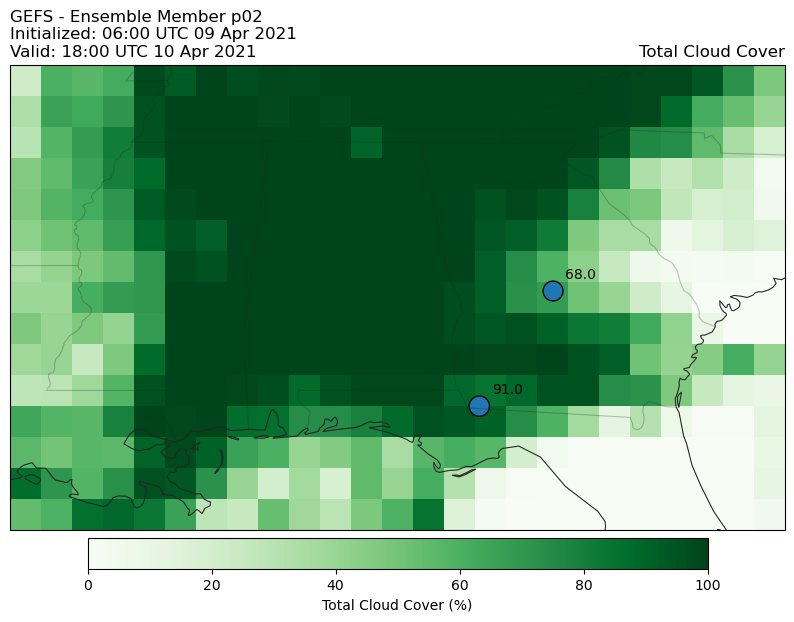

Weighted Average TCC: 79.74820143884892


In [11]:
member = 'p02'
df2, weighted_avg_tcc2 = sample_tcc_function(member=member, date=date, plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc2))

And again for `p03`:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-09 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


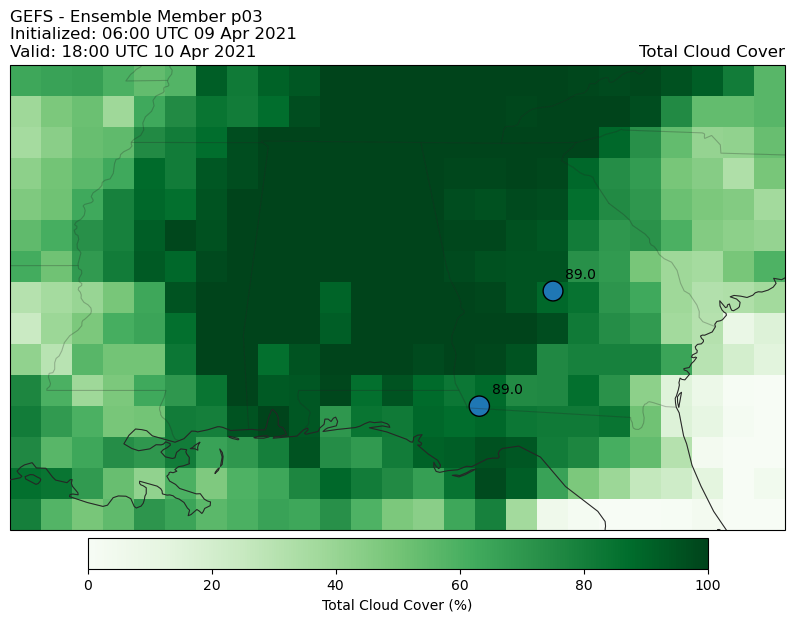

Weighted Average TCC: 89.0


In [12]:
member = 'p03'
df3, weighted_avg_tcc3 = sample_tcc_function(member=member, date=date, plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc3))

If there were only 3 members, we could stop there and calculate the standard deviation of weighted average TCCs from each member:

In [13]:
print(np.std([weighted_avg_tcc1, weighted_avg_tcc2, weighted_avg_tcc3]))

10.716068766970816


This is a relatively large standard deviation, indicating high uncertainty.

### Again for another day
Let's do the same thing, but for the next day. We will call our helper function inside a loop, iterating through ensemble members:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


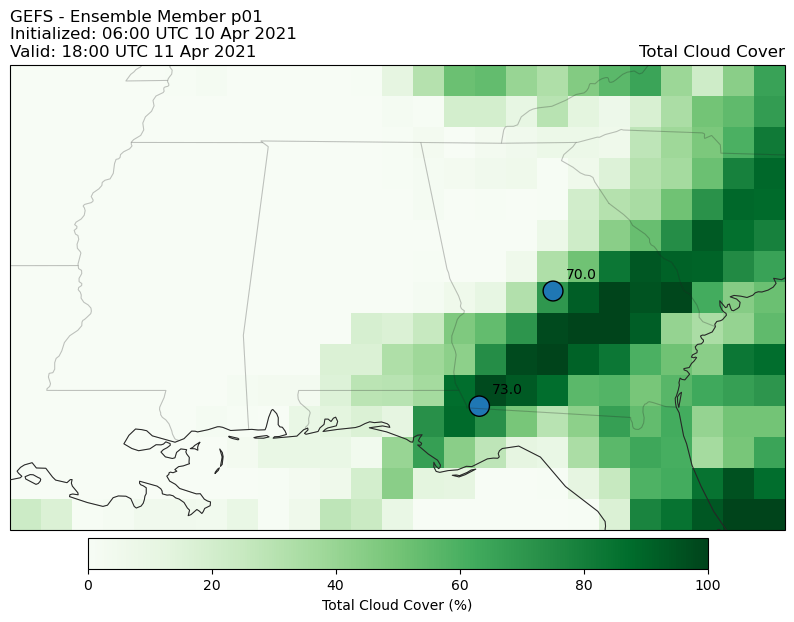

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


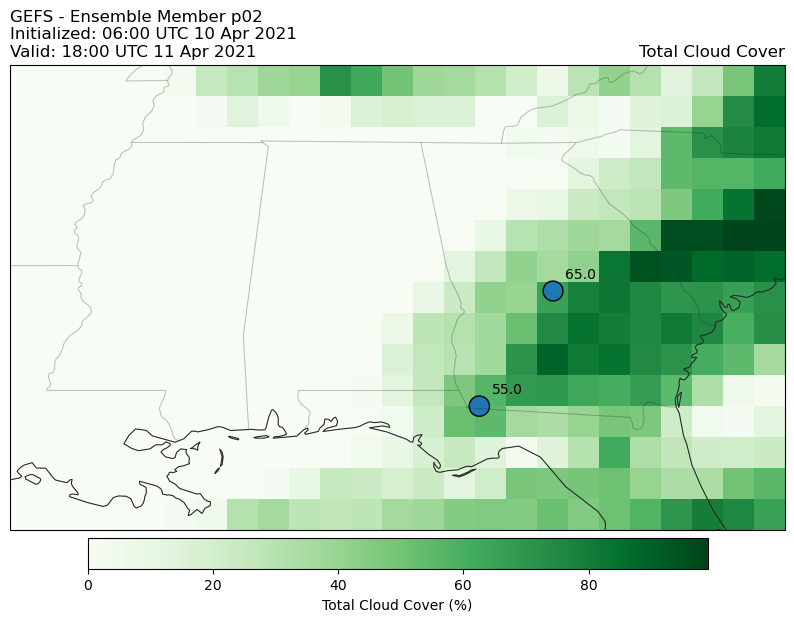

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-10 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


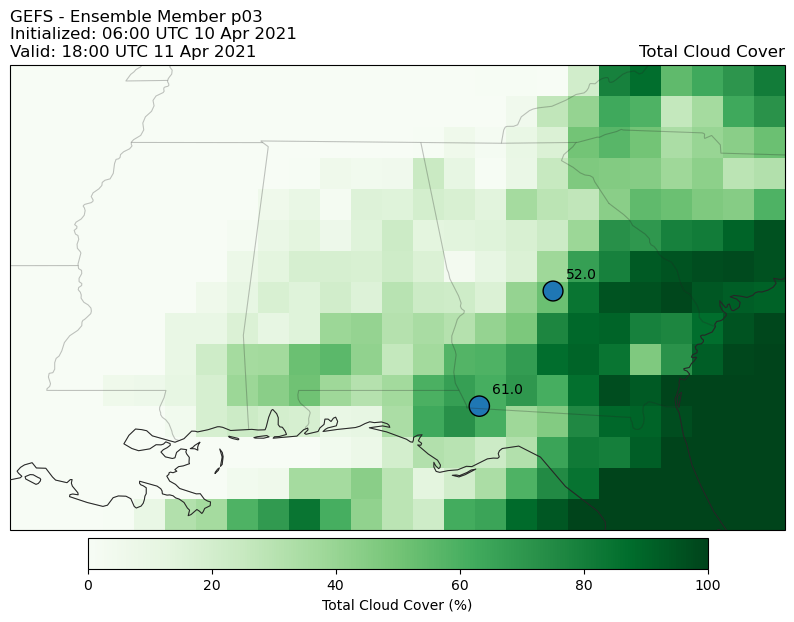

StDev of Weighted Avg TCC: 6.406722455538793
None


In [14]:
date = '2021-04-10 06:00'

num_members = 3 # up to 30

# list of GEFS ensemble members, e.g., 'p01', 'p02', etc.
member_list = [f"p{x:02d}" for x in range(1, num_members+1)]

df_dict = {}
weighted_avg_tcc_dict = {}
for x in range(0, num_members):
    df_dict[x], weighted_avg_tcc_dict[x] = sample_tcc_function(member=member_list[x],
    date=date, plants_df=plants_df_partial)

std_wavg_tcc = np.std(list(weighted_avg_tcc_dict.values()))
print(print('StDev of Weighted Avg TCC: ' + str(std_wavg_tcc)))

The standard deviation of weighted average TCC is lower for this forecast, indicating lower uncertainty. 

### And for a third day
One more time:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


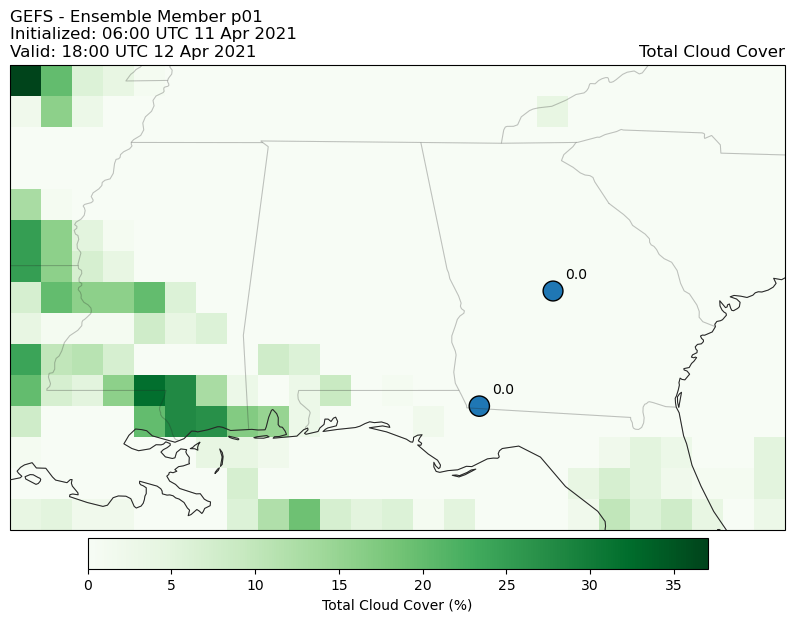

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


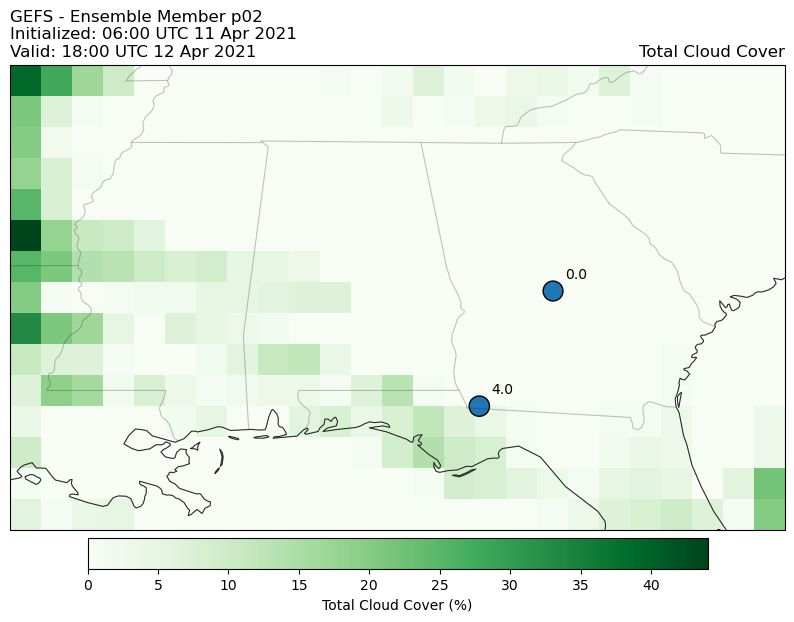

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Apr-11 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvlib_herbie_env\lib\site-packages\herbie\core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


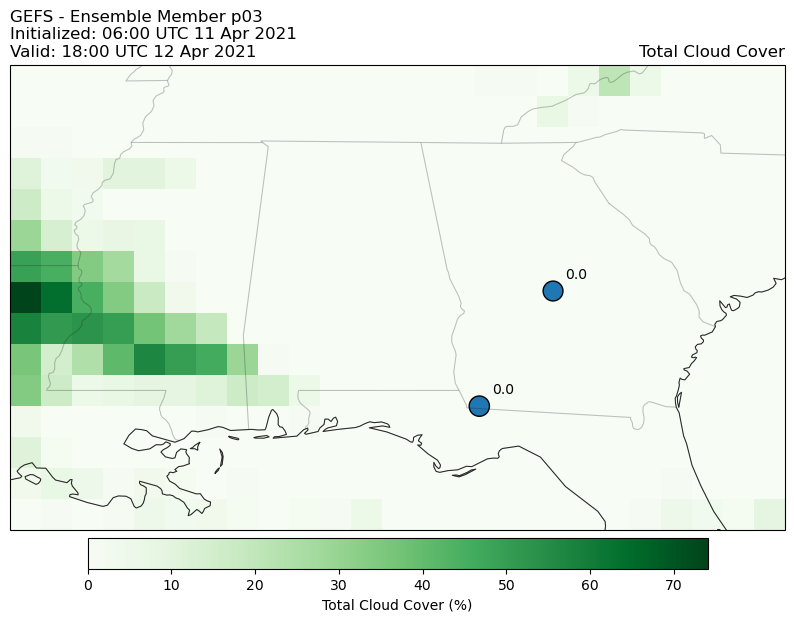

StDev of Weighted Avg TCC: 0.9631574381629712
None


In [15]:
date = '2021-04-11 06:00'

df_dict = {}
weighted_avg_tcc_dict = {}
for x in range(0, num_members):
    df_dict[x], weighted_avg_tcc_dict[x] = sample_tcc_function(member=member_list[x],
    date=date, plants_df=plants_df_partial)

std_wavg_tcc = np.std(list(weighted_avg_tcc_dict.values()))
print(print('StDev of Weighted Avg TCC: ' + str(std_wavg_tcc)))

This indicates vary low uncertainty, at least compared to the first two days. 

## Multiple forecasts at once
So far, we've worked with a single initialization time and a single valid time (i.e., a single forecast horizon or lead time). We can use `FastHerbie`, similar to what we did with HRRR data. We will loop through each member, subsetting the results and writing the dataset to a dictionary. We will also use the full list of plants instead of the partial list, and all 30 ensemble members.

**Note that this step could take 10-30 minutes due to the large number of downloads required.**

In [17]:
start = '2021-04-08 06:00'
end = '2021-04-11 06:00'
fxx_interval = 3 # time step of the forecast, GEFS has 3 hour intervals
DATES = pd.date_range(start=start, end=end, freq='24h')
fxx_range = range(27,46, fxx_interval)

num_members = 30 # out of 30, start with just a few ensemble members

# list of GEFS ensemble members, e.g., 'p01', 'p02', etc.
member_list = [f"p{x:02d}" for x in range(1, num_members+1)]

ds_dict = {}
for x in range(0,num_members):
    ds_dict[x] = FastHerbie(
        DATES, model="gefs", product="atmos.5", member=member_list[x],
        fxx=fxx_range).xarray("TCDC", remove_grib=False)
    
    # lat, lon extent for region of interest in GEFS coordinates
    # longitude has to be between 0 and 360
    min_lon = (region_extent[0]+360) % 360
    max_lon = (region_extent[1]+360) % 360
    min_lat = region_extent[2]
    max_lat = region_extent[3]

    # slice to region extent, add member name to tcc, drop unneeded coordinates
    # note that lat is sliced max to min because of order that latitude is stored in with GEFS
    # (I think...)
    ds_dict[x] = ds_dict[x].sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))
    ds_dict[x] = ds_dict[x].rename({'tcc':'tcc_' + member_list[x]})
    ds_dict[x] = ds_dict[x].drop_vars(['number', 'atmosphere', 'gribfile_projection'])
    print('member ' + str(x+1) + ' download complete')


member 1 download complete
member 2 download complete
member 3 download complete
member 4 download complete
member 5 download complete
member 6 download complete
member 7 download complete
member 8 download complete
member 9 download complete
member 10 download complete
member 11 download complete
member 12 download complete
member 13 download complete
member 14 download complete
member 15 download complete
member 16 download complete
member 17 download complete
member 18 download complete
member 19 download complete
member 20 download complete
member 21 download complete
member 22 download complete
member 23 download complete
member 24 download complete
member 25 download complete
member 26 download complete
member 27 download complete
member 28 download complete
member 29 download complete
member 30 download complete


Merge datasets, select data for each plant, and move it into a DataFrame:

In [18]:
# merge datasets
ds = xr.merge([ds_dict[i] for i in ds_dict])

# GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
lon_gefs = [(x + 360) % 360 for x in plants_df.longitude]

# select the whole list of sites at once
lats = xr.DataArray(plants_df.latitude.values, dims='plant_number') 
lons = xr.DataArray(lon_gefs, dims='plant_number')
df = ds.sel(latitude = lats, longitude = lons, method = 'nearest').to_dataframe()

# assign ac capacity based on plant_number and index in plants_df
df = df.merge(plants_df[['ac_capacity']], left_on='plant_number', right_index=True)

# remove index
df = df.reset_index()

# rename latitude, longitude columns to note that they came from the GEFS coordinates
# rename time to add utc
df = df.rename(columns={'latitude':'gefs_latitude','longitude':'gefs_longitude',
                        'time':'time_utc'
            })

Calculated weighted average TCC for each member, and then standard deviation across all members:

In [19]:
# loop through unique forecasts (unique 'time_utc' and 'step' values)
temp = {}
i=0
for time_utc in df['time_utc'].unique():
    for step in df['step'].unique():
        
        df_temp = df[(df['time_utc']==time_utc) & (df['step']==step)]
        out = df_temp.filter(regex='tcc').multiply(plants_df['ac_capacity'].values,axis='index').sum()/plants_df['ac_capacity'].sum()
        temp[i] = out.to_frame().T
        temp[i].insert(0, 'time_utc', time_utc)
        temp[i].insert(1, 'step', step)
        # because each time, step combination has a unique valid_time:
        valid_time = df_temp['valid_time'].unique()[0]
        # add valid_time
        temp[i].insert(2, 'valid_time', valid_time)
        i += 1

# concatenate results
weighted_avg_tcc = pd.concat(temp)
del temp, df_temp, df

# rename columns, set indices
weighted_avg_tcc.rename(columns={'valid_time':'valid_time_utc_end_of_interval'},
                                inplace=True)
weighted_avg_tcc.set_index(['time_utc', 'step','valid_time_utc_end_of_interval'],inplace=True)

# calculate stdev of weighted avg tcc for each valid_time_utc
weighted_avg_tcc.insert(0,'tcc_std',weighted_avg_tcc.filter(regex='tcc').std(axis=1))

weighted_avg_tcc = weighted_avg_tcc.reset_index().set_index('valid_time_utc_end_of_interval')

In [20]:
weighted_avg_tcc.head()

,time_utc,step,tcc_std,tcc_p01,tcc_p02,tcc_p03,tcc_p04,tcc_p05,tcc_p06,tcc_p07,...,tcc_p21,tcc_p22,tcc_p23,tcc_p24,tcc_p25,tcc_p26,tcc_p27,tcc_p28,tcc_p29,tcc_p30
valid_time_utc_end_of_interval,,,,,,,,,,,,,,,,,,,,,
2021-04-09 09:00:00,2021-04-08 06:00:00,1 days 03:00:00,10.594097,72.909722,73.415225,85.394371,85.516993,87.027070,69.295159,80.239163,...,92.539300,73.304281,76.921589,76.922826,65.496784,55.722008,65.989183,56.612114,74.107419,58.481366
2021-04-09 12:00:00,2021-04-08 06:00:00,1 days 06:00:00,7.452738,82.877432,82.416759,83.476011,90.387428,91.535667,76.028846,86.253424,...,95.957458,78.105697,82.181605,83.544063,76.524742,70.038102,78.880203,66.261093,82.142750,70.387697
2021-04-09 15:00:00,2021-04-08 06:00:00,1 days 09:00:00,3.571200,97.606383,91.362995,95.713828,96.994511,98.983801,84.190808,96.539138,...,98.045502,94.593305,97.196082,97.147674,92.878078,94.408121,88.133224,93.461830,93.819283,91.084546
2021-04-09 18:00:00,2021-04-08 06:00:00,1 days 12:00:00,5.625143,97.234803,88.233189,96.349030,97.463875,99.351667,84.577940,93.305169,...,97.210209,92.892931,97.631165,94.985416,94.819229,93.497753,88.597288,93.395851,85.662352,81.981003
2021-04-09 21:00:00,2021-04-08 06:00:00,1 days 15:00:00,3.429969,96.364933,96.878885,94.549175,97.494524,99.656702,97.076770,95.062293,...,96.024164,89.841374,96.358744,94.019266,96.109787,96.002287,96.780750,97.969432,88.509431,87.836666


## Time intervals
We want 1-hour interval data, bit GEFS has 3 hour intervals, with total cloud cover representing the 0-3 hour average [1]. We can make two additional copies of the data with the timestamps shifted -1 and -2 hours, concatenate, and then sort, to turn this into 1 hour data. 

[1] See "TCDC", total cloud cover, here https://www.nco.ncep.noaa.gov/pmb/products/gens/gep01.t00z.pgrb2a.0p50.f003.shtml.

_Note: We could have resampled to hourly and backfilled, but if there are gaps in our forecast timeseries (e.g., we left out nighttime from our FastHerbie pull), we wouldn't know which hours were "real" forecasts and which were filled in._

In [21]:
temp1 = weighted_avg_tcc.copy()
temp2 = weighted_avg_tcc.copy()
temp1.index = weighted_avg_tcc.index.shift(-1, freq='h')
temp2.index = weighted_avg_tcc.index.shift(-2, freq='h')
weighted_avg_tcc = pd.concat([weighted_avg_tcc, temp1, temp2])
del temp1, temp2

weighted_avg_tcc = weighted_avg_tcc.sort_index()

weighted_avg_tcc.head(9)

,time_utc,step,tcc_std,tcc_p01,tcc_p02,tcc_p03,tcc_p04,tcc_p05,tcc_p06,tcc_p07,...,tcc_p21,tcc_p22,tcc_p23,tcc_p24,tcc_p25,tcc_p26,tcc_p27,tcc_p28,tcc_p29,tcc_p30
valid_time_utc_end_of_interval,,,,,,,,,,,,,,,,,,,,,
2021-04-09 07:00:00,2021-04-08 06:00:00,1 days 03:00:00,10.594097,72.909722,73.415225,85.394371,85.516993,87.027070,69.295159,80.239163,...,92.539300,73.304281,76.921589,76.922826,65.496784,55.722008,65.989183,56.612114,74.107419,58.481366
2021-04-09 08:00:00,2021-04-08 06:00:00,1 days 03:00:00,10.594097,72.909722,73.415225,85.394371,85.516993,87.027070,69.295159,80.239163,...,92.539300,73.304281,76.921589,76.922826,65.496784,55.722008,65.989183,56.612114,74.107419,58.481366
2021-04-09 09:00:00,2021-04-08 06:00:00,1 days 03:00:00,10.594097,72.909722,73.415225,85.394371,85.516993,87.027070,69.295159,80.239163,...,92.539300,73.304281,76.921589,76.922826,65.496784,55.722008,65.989183,56.612114,74.107419,58.481366
2021-04-09 10:00:00,2021-04-08 06:00:00,1 days 06:00:00,7.452738,82.877432,82.416759,83.476011,90.387428,91.535667,76.028846,86.253424,...,95.957458,78.105697,82.181605,83.544063,76.524742,70.038102,78.880203,66.261093,82.142750,70.387697
2021-04-09 11:00:00,2021-04-08 06:00:00,1 days 06:00:00,7.452738,82.877432,82.416759,83.476011,90.387428,91.535667,76.028846,86.253424,...,95.957458,78.105697,82.181605,83.544063,76.524742,70.038102,78.880203,66.261093,82.142750,70.387697
2021-04-09 12:00:00,2021-04-08 06:00:00,1 days 06:00:00,7.452738,82.877432,82.416759,83.476011,90.387428,91.535667,76.028846,86.253424,...,95.957458,78.105697,82.181605,83.544063,76.524742,70.038102,78.880203,66.261093,82.142750,70.387697
2021-04-09 13:00:00,2021-04-08 06:00:00,1 days 09:00:00,3.571200,97.606383,91.362995,95.713828,96.994511,98.983801,84.190808,96.539138,...,98.045502,94.593305,97.196082,97.147674,92.878078,94.408121,88.133224,93.461830,93.819283,91.084546
2021-04-09 14:00:00,2021-04-08 06:00:00,1 days 09:00:00,3.571200,97.606383,91.362995,95.713828,96.994511,98.983801,84.190808,96.539138,...,98.045502,94.593305,97.196082,97.147674,92.878078,94.408121,88.133224,93.461830,93.819283,91.084546
2021-04-09 15:00:00,2021-04-08 06:00:00,1 days 09:00:00,3.571200,97.606383,91.362995,95.713828,96.994511,98.983801,84.190808,96.539138,...,98.045502,94.593305,97.196082,97.147674,92.878078,94.408121,88.133224,93.461830,93.819283,91.084546


Now, let's plot the results, to see how the standard deviation of weighted average TCC varies over time:

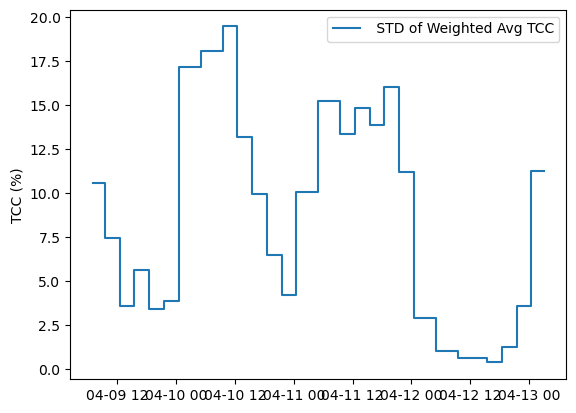

In [22]:
plt.plot(weighted_avg_tcc.index, weighted_avg_tcc.tcc_std, drawstyle='steps-mid',
         label=' STD of Weighted Avg TCC')
plt.legend()
plt.ylabel('TCC (%)')
plt.show()

Let's save that dataframe for use later:

In [23]:
weighted_avg_tcc.to_pickle('example_data/weighted_avg_tcc_20210408.pkl')

And that's the end of this notebook. We've now walked though in introduction of calculating the standard deviation of the weighted average of Total Cloud Cover from the GEFS model, our second indicator of forecast uncertainty. Please move on to the next notebook, where we pull both uncertainty indicators in together: [06_indicators_of_forecast_error.ipynb](06_indicators_of_forecast_error.ipynb).